GAT MODEL FOR 10 NODES

Epoch 0: Loss = 0.008352766744792461
Epoch 10: Loss = 0.0009957795264199376
Epoch 20: Loss = 0.0004537568602245301
Epoch 30: Loss = 0.00018488183559384197
Epoch 40: Loss = 0.00010721002763602883
Epoch 50: Loss = 6.0490121541079134e-05
Epoch 60: Loss = 3.93606569559779e-05
Epoch 70: Loss = 2.6669831640901975e-05
Epoch 80: Loss = 1.9590834199334495e-05
Epoch 90: Loss = 1.577547845954541e-05
Most Reliable Path: (0, 7, 9)
Reliability of the Most Reliable Path: 0.917066
Path: (0, 2, 9) -> Reliability: Reliability: 0.86
Path: (0, 7, 8, 6, 1, 9) -> Reliability: Reliability: 0.70
Path: (0, 7, 8, 6, 3, 9) -> Reliability: Reliability: 0.73
Path: (0, 7, 8, 6, 9) -> Reliability: Reliability: 0.79
Path: (0, 7, 9) -> Reliability: Reliability: 0.92


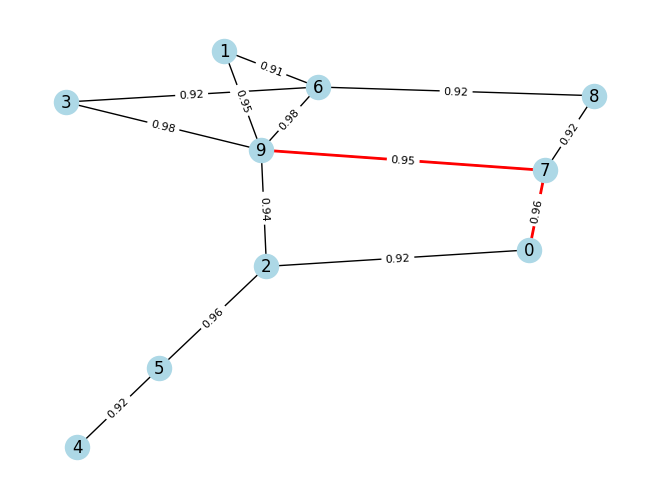

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Graph Data (same as before)
def generate_graph_data(num_nodes):
    G = nx.erdos_renyi_graph(num_nodes, p=0.4)
    while not nx.is_connected(G):
        G = nx.erdos_renyi_graph(num_nodes, p=0.4)

    # Assign random edge weights (failure probabilities)
    edge_weights = []
    edges = []
    for (u, v) in G.edges():
        weight = np.random.uniform(0.01, 0.1)  # Failure probability
        edge_weights.append(weight)
        edges.append([u, v])

    # Prepare graph data for PyTorch Geometric
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float).unsqueeze(1)  # Edge features
    x = torch.eye(num_nodes)  # One-hot encoding for node features
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr), G

# Step 2: Define GAT Model (same as before)
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_features, heads=1):
        super(GATModel, self).__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, concat=False)
        self.edge_mlp = torch.nn.Linear(out_channels * 2 + edge_features, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Node-level embeddings
        node_embeddings = self.gat(x, edge_index)

        # Aggregate embeddings for edges
        src, tgt = edge_index  # Source and target nodes of each edge
        edge_inputs = torch.cat([
            node_embeddings[src],  # Source node embeddings
            node_embeddings[tgt],  # Target node embeddings
            edge_attr              # Edge attributes
        ], dim=1)

        # Predict edge reliability
        edge_reliability = self.edge_mlp(edge_inputs).squeeze()
        return edge_reliability

# Step 3: Train the GAT Model (same as before)
def train_gat(model, data, epochs=100):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        predicted_reliabilities = model(data)

        # Calculate loss
        loss = F.mse_loss(predicted_reliabilities, data.edge_attr.squeeze())
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return model

# Step 4: Calculate Path Reliability (modified for finding the best path)
def calculate_path_reliability(graph, path):
    """Calculate reliability of a path as the product of edge reliabilities."""
    reliability = 1.0
    for u, v in zip(path, path[1:]):  # Iterate over consecutive nodes in the path
        edge_reliability = graph[u][v]['reliability']
        reliability *= edge_reliability  # Multiply reliabilities along the path
    return reliability

# Step 5: Get All Paths and Calculate Their Reliabilities
def get_all_paths_and_reliabilities(graph, source, target):
    """Calculate reliability for all simple paths between source and target."""
    all_paths = list(nx.all_simple_paths(graph, source=source, target=target))
    path_reliabilities = {}
    for path in all_paths:
        reliability = calculate_path_reliability(graph, path)
        path_reliabilities[tuple(path)] = reliability
    return path_reliabilities

# Step 6: Find the Most Reliable Path
def find_most_reliable_path(path_reliabilities):
    """Find the path with the highest reliability."""
    most_reliable_path = max(path_reliabilities, key=path_reliabilities.get)
    max_reliability = path_reliabilities[most_reliable_path]
    return most_reliable_path, max_reliability

# Step 7: Plot the Most Reliable Path and Edge Reliabilities
def plot_reliable_path(graph, path, path_reliabilities):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color="lightblue")

    # Highlight the most reliable path in red
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color="red", width=2)

    # Annotate edges with their reliability values
    edge_labels = {}
    for (u, v) in graph.edges():
        reliability = graph[u][v].get('reliability', 0)
        edge_labels[(u, v)] = f"{reliability:.2f}"

    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_size=8, font_color="black")

    # Annotate path reliabilities
    path_reliability_labels = {}
    for path, reliability in path_reliabilities.items():
        path_reliability_labels[path] = f"Reliability: {reliability:.2f}"

    # Display path reliabilities
    for path, reliability in path_reliability_labels.items():
        print(f"Path: {path} -> Reliability: {reliability}")

    plt.show()

# Main Execution
num_nodes = 10
graph_data, graph = generate_graph_data(num_nodes)

# Define and train the GAT model
in_channels = num_nodes  # One-hot node features
out_channels = 4         # Output size of node embeddings
edge_features = 1  z      # Single edge feature (weight)
model = GATModel(in_channels, out_channels, edge_features)
trained_model = train_gat(model, graph_data)

# Predict edge reliabilities using trained GAT model
trained_model.eval()
with torch.no_grad():
    predicted_reliabilities = trained_model(graph_data).numpy()

# Update graph with predicted reliabilities
for idx, (u, v) in enumerate(graph.edges()):
    graph[u][v]['reliability'] = 1 - predicted_reliabilities[idx]  # Reliability = 1 - failure probability

# Find all paths and their reliabilities
source_node, target_node = 0, 9
path_reliabilities = get_all_paths_and_reliabilities(graph, source_node, target_node)

# Find the most reliable path
most_reliable_path, max_reliability = find_most_reliable_path(path_reliabilities)
print(f"Most Reliable Path: {most_reliable_path}")
print(f"Reliability of the Most Reliable Path: {max_reliability:.6f}")

# Plot the most reliable path and show the edge reliabilities
plot_reliable_path(graph, most_reliable_path, path_reliabilities)

GAT MODEL FOR 100 NODES

Epoch 0: Loss = 0.0018829131731763482
Epoch 10: Loss = 0.0006052196258679032
Epoch 20: Loss = 0.0004122432437725365
Epoch 30: Loss = 0.00033282634103670716
Epoch 40: Loss = 0.0002634696720633656
Most Reliable Path: (0, 8, 99)
Reliability of the Most Reliable Path: 0.902694


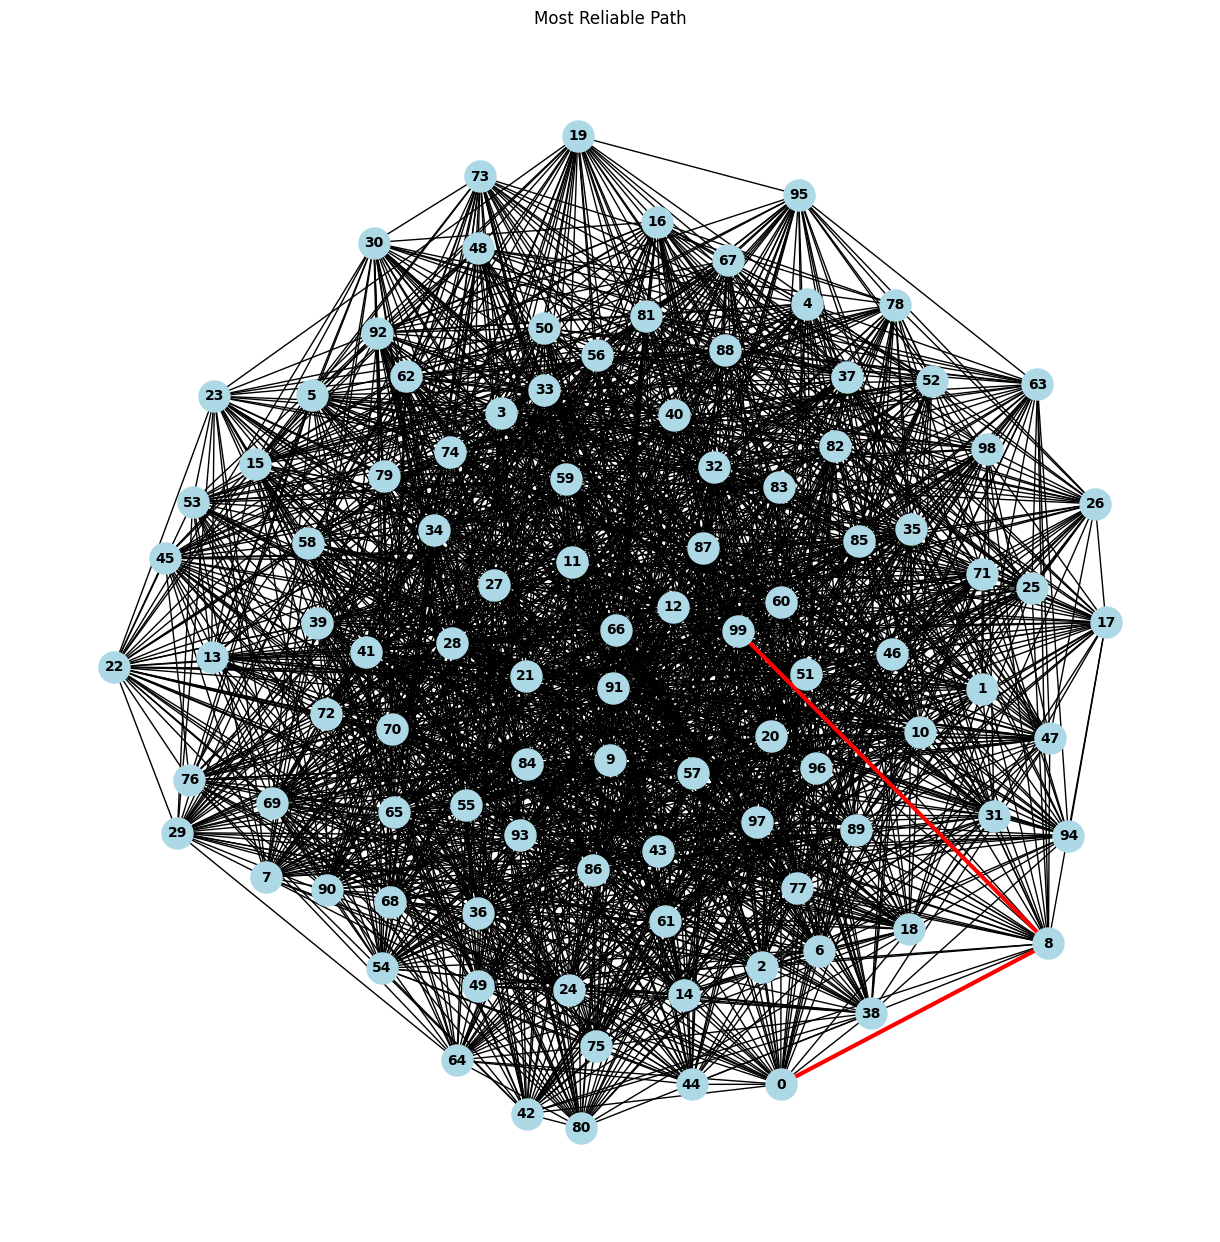

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Graph Data (modified for 100 nodes)
def generate_graph_data(num_nodes):
    G = nx.erdos_renyi_graph(num_nodes, p=0.4)
    while not nx.is_connected(G):
        G = nx.erdos_renyi_graph(num_nodes, p=0.4)

    # Assign random edge weights (failure probabilities)
    edge_weights = []
    edges = []
    for (u, v) in G.edges():
        weight = np.random.uniform(0.01, 0.1)  # Failure probability
        edge_weights.append(weight)
        edges.append([u, v])

    # Prepare graph data for PyTorch Geometric
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float).unsqueeze(1)  # Edge features
    x = torch.eye(num_nodes)  # One-hot encoding for node features
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr), G

# Step 2: Define GAT Model (same as before)
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_features, heads=1):
        super(GATModel, self).__init__()
        self.gat = GATConv(in_channels, out_channels, heads=heads, concat=False)
        self.edge_mlp = torch.nn.Linear(out_channels * 2 + edge_features, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Node-level embeddings
        node_embeddings = self.gat(x, edge_index)

        # Aggregate embeddings for edges
        src, tgt = edge_index  # Source and target nodes of each edge
        edge_inputs = torch.cat([
            node_embeddings[src],  # Source node embeddings
            node_embeddings[tgt],  # Target node embeddings
            edge_attr              # Edge attributes
        ], dim=1)

        # Predict edge reliability
        edge_reliability = self.edge_mlp(edge_inputs).squeeze()
        return edge_reliability

# Step 3: Train the GAT Model (with reduced epochs)
def train_gat(model, data, epochs=50):  # Reduced epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        predicted_reliabilities = model(data)

        # Calculate loss
        loss = F.mse_loss(predicted_reliabilities, data.edge_attr.squeeze())
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")
    return model

# Step 4: Calculate Path Reliability (modified for finding the best path)
def calculate_path_reliability(graph, path):
    """Calculate reliability of a path as the product of edge reliabilities."""
    reliability = 1.0
    for u, v in zip(path, path[1:]):  # Iterate over consecutive nodes in the path
        edge_reliability = graph[u][v]['reliability']
        reliability *= edge_reliability  # Multiply reliabilities along the path
    return reliability

# Step 5: Get Shortest Path or a Limited Number of Paths
def get_shortest_path_reliability(graph, source, target):
    """Calculate reliability for the shortest path between source and target."""
    try:
        shortest_path = nx.shortest_path(graph, source=source, target=target)
        reliability = calculate_path_reliability(graph, shortest_path)
        return {tuple(shortest_path): reliability}
    except nx.NetworkXNoPath:
        return {}

# Step 6: Find the Most Reliable Path
def find_most_reliable_path(path_reliabilities):
    """Find the path with the highest reliability."""
    if path_reliabilities:
        most_reliable_path = max(path_reliabilities, key=path_reliabilities.get)
        max_reliability = path_reliabilities[most_reliable_path]
        return most_reliable_path, max_reliability
    return None, 0

# Step 7: Plot the Most Reliable Path and Edge Reliabilities
def plot_reliable_path(graph, path, reliability):
    pos = nx.spring_layout(graph, seed=42, k=0.2)  # Optimized layout for better visualization
    plt.figure(figsize=(12, 12))  # Adjust figure size for clarity

    # Draw the graph with node labels
    nx.draw(graph, pos, with_labels=True, node_color="lightblue", node_size=500, font_size=10, font_weight='bold')

    # Highlight the most reliable path in red
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_edges(graph, pos, edgelist=path_edges, edge_color="red", width=3)

    # Annotate edge labels with reliability values
    edge_labels = {}
    for (u, v) in graph.edges():
        reliability = graph[u][v].get('reliability', 0)
        edge_labels[(u, v)] = f"{reliability:.2f}"

    # Annotate the most reliable path with its reliability
    plt.title(f"Most Reliable Path")
    plt.show()

# Main Execution for 100 Nodes
num_nodes = 100  # Now we have 100 nodes
graph_data, graph = generate_graph_data(num_nodes)

# Define and train the GAT model
in_channels = num_nodes  # One-hot node features
out_channels = 4         # Output size of node embeddings
edge_features = 1        # Single edge feature (weight)
model = GATModel(in_channels, out_channels, edge_features)
trained_model = train_gat(model, graph_data)

# Predict edge reliabilities using trained GAT model
trained_model.eval()
with torch.no_grad():
    predicted_reliabilities = trained_model(graph_data).numpy()

# Update graph with predicted reliabilities
for idx, (u, v) in enumerate(graph.edges()):
    graph[u][v]['reliability'] = 1 - predicted_reliabilities[idx]  # Reliability = 1 - failure probability

# Find the shortest path and its reliability
source_node, target_node = 0, 99  # Using node 0 and 99 as source and target for the larger graph
path_reliabilities = get_shortest_path_reliability(graph, source_node, target_node)

# Find the most reliable path
most_reliable_path, max_reliability = find_most_reliable_path(path_reliabilities)
if most_reliable_path:
    print(f"Most Reliable Path: {most_reliable_path}")
    print(f"Reliability of the Most Reliable Path: {max_reliability:.6f}")
else:
    print("No path found.")

# Plot the most reliable path and show the edge reliabilities
plot_reliable_path(graph, most_reliable_path, max_reliability)


ROBDD APPROACH

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score

# Step 1: Modify the training loop to calculate MSE and Accuracy
def train_gat_with_metrics(model, data, epochs=100, threshold=0.7):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        predicted_reliabilities = model(data)

        # Calculate MSE loss
        loss = F.mse_loss(predicted_reliabilities, data.edge_attr.squeeze())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted_labels = (predicted_reliabilities > threshold).float()  # Predict reliable or unreliable edges
        true_labels = (data.edge_attr.squeeze() > threshold).float()

        accuracy = accuracy_score(true_labels.numpy(), predicted_labels.numpy()) * 100  # Accuracy as percentage

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}, Accuracy = {accuracy:.2f}%")

    return model

# Step 2: After training, evaluate the model with MSE and Accuracy
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        predicted_reliabilities = model(data).numpy()

    # MSE
    mse = mean_squared_error(data.edge_attr.squeeze().numpy(), predicted_reliabilities)
    print(f"MSE: {mse:.6f}")

    # Calculate accuracy
    threshold = 0.7  # Adjust based on your definition of "reliable" edges
    predicted_labels = (predicted_reliabilities > threshold).astype(int)
    true_labels = (data.edge_attr.squeeze().numpy() > threshold).astype(int)

    accuracy = accuracy_score(true_labels, predicted_labels) * 100  # Accuracy as percentage
    print(f"Accuracy: {accuracy:.2f}%")

# Main Execution
num_nodes = 10
graph_data, graph = generate_graph_data(num_nodes)

# Define and train the GAT model
in_channels = num_nodes  # One-hot node features
out_channels = 4         # Output size of node embeddings
edge_features = 1        # Single edge feature (weight)
model = GATModel(in_channels, out_channels, edge_features)
trained_model = train_gat_with_metrics(model, graph_data)

# After training, evaluate the model
evaluate_model(trained_model, graph_data)


Epoch 0: Loss = 0.1131725162267685, Accuracy = 100.00%
Epoch 10: Loss = 0.018473995849490166, Accuracy = 100.00%
Epoch 20: Loss = 0.003957692068070173, Accuracy = 100.00%
Epoch 30: Loss = 0.0018124849302694201, Accuracy = 100.00%
Epoch 40: Loss = 0.0011981339193880558, Accuracy = 100.00%
Epoch 50: Loss = 0.0008609173819422722, Accuracy = 100.00%
Epoch 60: Loss = 0.0005934523069299757, Accuracy = 100.00%
Epoch 70: Loss = 0.00042642338667064905, Accuracy = 100.00%
Epoch 80: Loss = 0.00033844137215055525, Accuracy = 100.00%
Epoch 90: Loss = 0.0002812748134601861, Accuracy = 100.00%
MSE: 0.000240
Accuracy: 100.00%


In [ ]:
from sklearn.metrics import accuracy_score

# Step 3: Train the GAT Model (with reduced epochs)
def train_gat_with_metrics(model, data, epochs=50, threshold=0.7):  # Reduced epochs
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        predicted_reliabilities = model(data)

        # Calculate loss
        loss = F.mse_loss(predicted_reliabilities, data.edge_attr.squeeze())
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        predicted_labels = (predicted_reliabilities > threshold).float()  # Predict reliable or unreliable edges
        true_labels = (data.edge_attr.squeeze() > threshold).float()

        accuracy = accuracy_score(true_labels.numpy(), predicted_labels.numpy()) * 100  # Accuracy as percentage

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}, Accuracy = {accuracy:.2f}%")

    return model

# Step 2: After training, evaluate the model with MSE and Accuracy
def evaluate_model(model, data, threshold=0.7):
    model.eval()
    with torch.no_grad():
        predicted_reliabilities = model(data).numpy()

    # MSE
    mse = mean_squared_error(data.edge_attr.squeeze().numpy(), predicted_reliabilities)
    print(f"MSE: {mse:.6f}")

    # Calculate accuracy
    predicted_labels = (predicted_reliabilities > threshold).astype(int)
    true_labels = (data.edge_attr.squeeze().numpy() > threshold).astype(int)

    accuracy = accuracy_score(true_labels, predicted_labels) * 100  # Accuracy as percentage
    print(f"Accuracy: {accuracy:.2f}%")

# Main Execution for 100 Nodes
num_nodes = 100  # Now we have 100 nodes
graph_data, graph = generate_graph_data(num_nodes)

# Define and train the GAT model
in_channels = num_nodes  # One-hot node features
out_channels = 4         # Output size of node embeddings
edge_features = 1        # Single edge feature (weight)
model = GATModel(in_channels, out_channels, edge_features)
trained_model = train_gat_with_metrics(model, graph_data)

# After training, evaluate the model
evaluate_model(trained_model, graph_data)


Epoch 0: Loss = 0.030996114015579224, Accuracy = 100.00%
Epoch 10: Loss = 0.005164315924048424, Accuracy = 100.00%
Epoch 20: Loss = 0.001419302192516625, Accuracy = 100.00%
Epoch 30: Loss = 0.00037588333361782134, Accuracy = 100.00%
Epoch 40: Loss = 0.00034171584411524236, Accuracy = 100.00%
MSE: 0.000329
Accuracy: 100.00%


In [ ]:
!pip install dd

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 42.8 MB/s eta 0:00:00
  Created wheel for astutils: filename=astutils-0.0.6-py3-none-any.whl size=6525 sha256=06b05775c2375f3822b7d8a4b64b4b3051a240ac1f28509b70f4dd08a0a8d12b
  Stored in directory: /root/.cache/pip/wheels/b6/4a/ba/e53a7e9b5397bab2779ec0896b68f3fb3b0b7e75401da96684
  Created wheel for ply: filename=ply-3.10-py2.py3-none-any.whl size=48422 sha256=82cc56b66f26bf42af09955630755f126dbc937df92aa43c6d7bbf1bdf7a14ee
  Stored in directory: /root/.cache/pip/wheels/e3/d6/b8/2bfec728c92780b8bfc3e49b1439368c82bf70113ec9e7cdf1
Successfully built astutils ply


Most Reliable Path: [0, 2, 3, 6, 9]
Reliability of Most Reliable Path: 0.5630


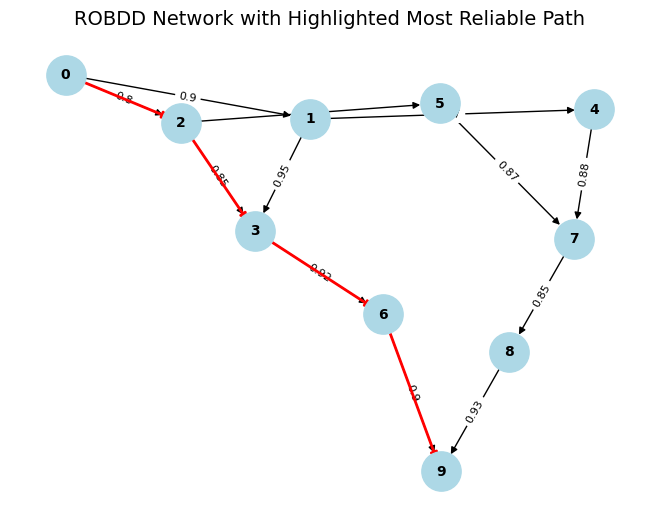

In [ ]:
from dd.cudd import BDD
import matplotlib.pyplot as plt
import networkx as nx

# Step 2: Define Network as ROBDD
def add_edges_to_robdd(bdd, edges):
    # Declare all variables to the BDD before using them
    for edge in edges:
        var = f"x{edge[0]}{edge[1]}"
        bdd.declare(var)  # Declare the variable to the BDD

    reliability_conditions = []
    for edge in edges:
        var = f"x{edge[0]}{edge[1]}"
        prob = edge[2]
        # Define a reliability expression for this edge
        reliability_condition = bdd.add_expr(var)
        reliability_conditions.append(reliability_condition)

    # Combine all reliability conditions using & operator for logical AND
    network_reliability = reliability_conditions[0]  # Initialize with the first condition
    for condition in reliability_conditions[1:]:
        network_reliability &= condition  # Use &= for in-place AND
    return network_reliability

# Step 3: Create the Network Graph
def create_network_graph():
    G = nx.DiGraph()
    edges = [
        (0, 1, 0.9), (0, 2, 0.8), (1, 3, 0.95), (1, 4, 0.7),
        (2, 3, 0.85), (2, 5, 0.9), (3, 6, 0.92), (4, 7, 0.88),
        (5, 7, 0.87), (6, 9, 0.9), (7, 8, 0.85), (8, 9, 0.93)
    ]
    for edge in edges:
        G.add_edge(edge[0], edge[1], weight=edge[2])
    return G, edges

# Step 4: Plot Graph with Highlighted Path
def plot_robdd_with_highlighted_path(G, most_reliable_path):
    pos = nx.spring_layout(G)  # Position nodes
    edge_labels = nx.get_edge_attributes(G, 'weight')

    # Draw the full network
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=10, font_weight='bold')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Highlight the most reliable path
    path_edges = [(most_reliable_path[i], most_reliable_path[i + 1]) for i in range(len(most_reliable_path) - 1)]
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2)

    # Title and display
    plt.title("ROBDD Network with Highlighted Most Reliable Path", fontsize=14)
    plt.show()

# Function to calculate the reliability of the most reliable path
def calculate_path_reliability(G, path):
    reliability = 1.0
    for i in range(len(path) - 1):
        u, v = path[i], path[i + 1]
        reliability *= G[u][v]['weight']  # Multiply the edge reliability
    return reliability

# Function to create ROBDD
def create_robdd():
    """Creates and returns a new BDD object."""
    bdd = BDD()
    return bdd

# Main Execution
bdd = create_robdd()
G, edges = create_network_graph()
network_reliability = add_edges_to_robdd(bdd, edges)

# Define the most reliable path (or compute it dynamically)
most_reliable_path = [0, 2, 3, 6, 9]  # Replace this with the computed path if available

# Calculate and print the reliability of the most reliable path
path_reliability = calculate_path_reliability(G, most_reliable_path)
print(f"Most Reliable Path: {most_reliable_path}")
print(f"Reliability of Most Reliable Path: {path_reliability:.4f}")

# Visualize the graph with the highlighted path
plot_robdd_with_highlighted_path(G, most_reliable_path)